# Exploratory Data Analysis

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shapely.geometry
import geopandas as gpd
from pandas.plotting import scatter_matrix
from pandas.plotting import parallel_coordinates

# Load NUTS Regions

In [3]:
filepath = "data/nuts_60m.gpkg"

gdf_nuts = gpd.read_file(
    filepath, 
    ignore_fields=['name_latn', 'nuts_name', 'population'],
    driver='GPKG')
gdf_nuts = gdf_nuts.rename(
    columns={'cntr_code': 'country'})
gdf_nuts = gdf_nuts.set_index("nuts_id")
gdf_nuts.head(2)

,levl_code,country,geometry
nuts_id,,,
AT,0,AT,"MULTIPOLYGON (((16.94000 48.61700, 16.95000 48..."
BG,0,BG,"MULTIPOLYGON (((28.57900 43.73900, 28.53000 43..."


# Load Normalized Amenity Features

In [4]:
filepath = "data/europe-amenity-features.csv.gz"

df = pd.read_csv(filepath, index_col='nuts_id')
df.head(2)

,parking,bench,place_of_worship,restaurant,school,parking_space,fuel,waste_basket,cafe,fast_food,...,car_wash,marketplace,bus_station,college,public_building,university,charging_station,bicycle_rental,veterinary,theatre
nuts_id,,,,,,,,,,,,,,,,,,,,,
AL,0.000605,0.0004,0.000323,0.000749,0.000343,0.000018,0.000475,0.00002,0.00063,0.000145,...,0.0001,0.000053,0.000035,0.000005,7.027518e-07,0.000038,0.000001,0.000009,0.000008,0.000013
AL0,0.000605,0.0004,0.000323,0.000749,0.000343,0.000018,0.000475,0.00002,0.00063,0.000145,...,0.0001,0.000053,0.000035,0.000005,7.027518e-07,0.000038,0.000001,0.000009,0.000008,0.000013


# Compare Amenities in Between

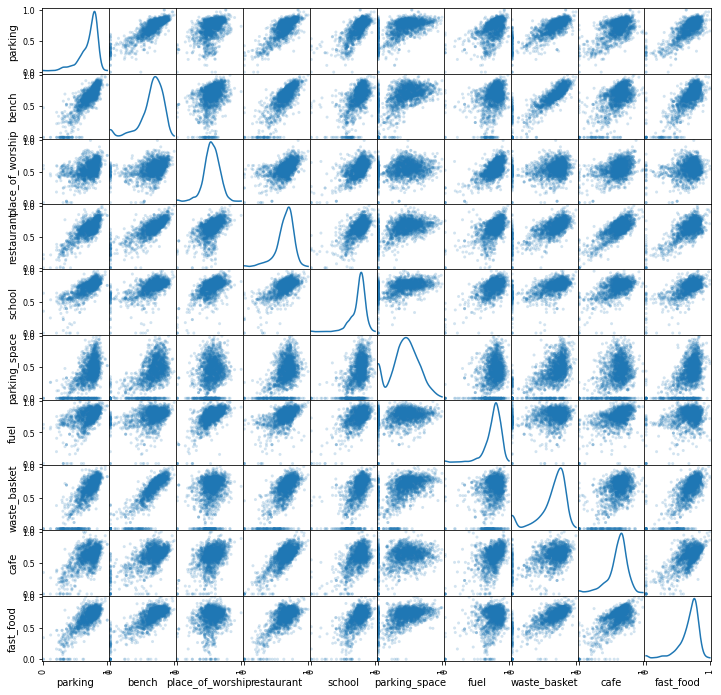

In [22]:
import warnings
from matplotlib.cbook import MatplotlibDeprecationWarning

mask = ~df.isna().all(axis=1)
df_tmp = df[mask].copy()
df_tmp = df_tmp.applymap(
    lambda x: np.log10(x * 100_000) if x > 0 else np.nan)

df_tmp = (df_tmp - df_tmp.min()) / \
         (df_tmp.max() - df_tmp.min())
df_tmp = df_tmp.fillna(0)

with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore", category=MatplotlibDeprecationWarning)
    scatter_matrix(
        df_tmp[df_tmp.columns[:10]], 
        alpha=0.2, 
        figsize=(12, 12), 
        diagonal='kde');

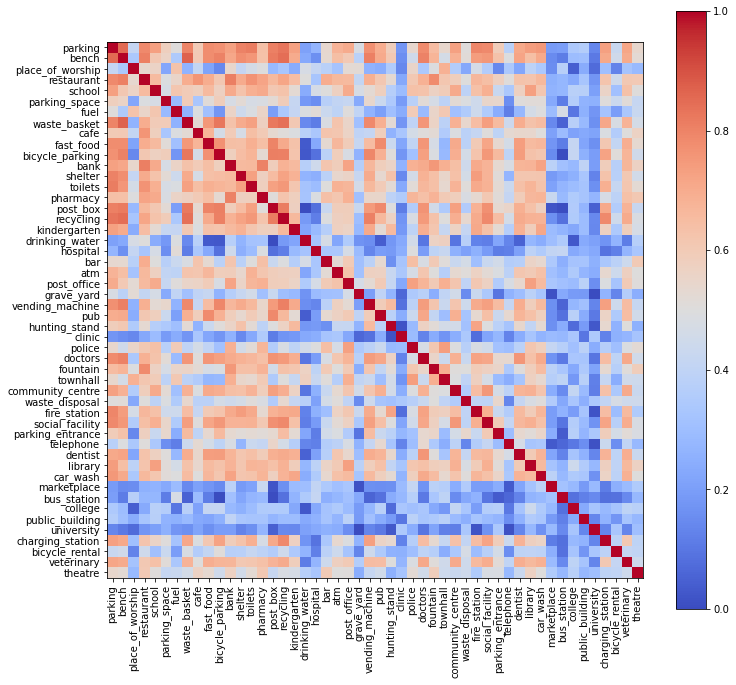

In [21]:
df_corr = df_tmp.corr()

plt.figure(figsize=(12, 11))
plt.imshow(df_corr, cmap='coolwarm', vmin=0, vmax=1)
plt.colorbar()
locs = range(len(df_corr.columns))
plt.xticks(locs, df_corr.columns, rotation=90, fontsize=10)
plt.yticks(locs, df_corr.columns, fontsize=10)
plt.grid(False);

# Visualize Data on a Map

In [232]:
# Filter by NUTS level and extent
amenity = "restaurant"
nuts_level = 3

EXTENT = [-19.6,32.9,47.7,72.2]  # Europe without colonies
mask = (gdf_nuts['levl_code'] == nuts_level) \
     & gdf_nuts.within(shapely.geometry.box(*EXTENT))

gdf_tmp = gdf_nuts[mask].copy()
s_restaurant = (df[amenity] * 100_000).copy()
gdf_tmp = gdf_tmp.join(s_restaurant)

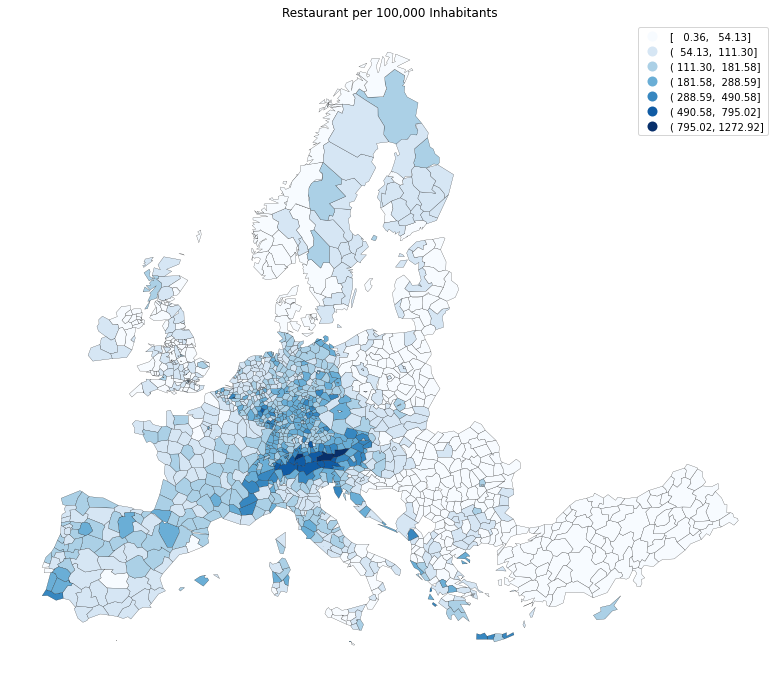

In [233]:
fig, ax = plt.subplots(figsize=(16, 12))

gdf_tmp.to_crs(epsg='3035').plot(
    ax=ax,
    column=amenity,
    cmap='Blues',
    legend=True,
    linewidth=0.2,
    scheme='natural_breaks',
    k=7,
    edgecolor='k')

ax.set_title(f"{amenity.title()} per 100,000 Inhabitants")
ax.set_axis_off();

# Parallel Coordinates Comparision between two Countries

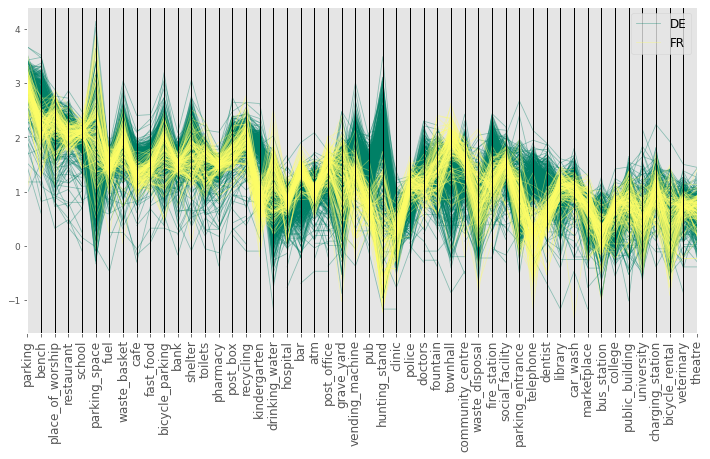

In [212]:
# Remove all rows that have no values and filter for countries
mask = (df.index.str.startswith('DE') | df.index.str.startswith('FR')) \
     & (~df.isna().all(axis=1))

df_subset = df[mask].copy()
df_subset = df_subset.applymap(lambda x: np.log10(x * 100_000) if x > 0 else np.nan)
df_subset['country'] = df_subset.index.str[:2]

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(12, 6))

    parallel_coordinates(
        df_subset,
        ax=ax,
        axvlines=True,
        alpha=0.4,
        class_column='country',
        linewidth=0.8,
        colormap='summer');
    
    ax.xaxis.set_tick_params(rotation=90, labelsize=12)    
    ax.yaxis.set_tick_params(labelsize=9)
    ax.legend(fontsize=12);

# Embedding of Features (PCA)

In [191]:
from sklearn.decomposition import PCA

In [192]:
mask = (df.index.str.startswith('DE') | df.index.str.startswith('FR')) \
     & (~df.isna().all(axis=1))

df_subset = df[mask].copy()
df_subset = df_subset.applymap(lambda x: np.log10(x * 100_000) if x > 0 else -2)

In [201]:
X = df_subset.values
X = (X - X.min()) / (X.max() - X.min())
y = df_subset.index.str[:2].map({ 'DE': 0, 'FR': 1 })

pca = PCA(n_components=2)
X_embedded = pca.fit_transform(X)

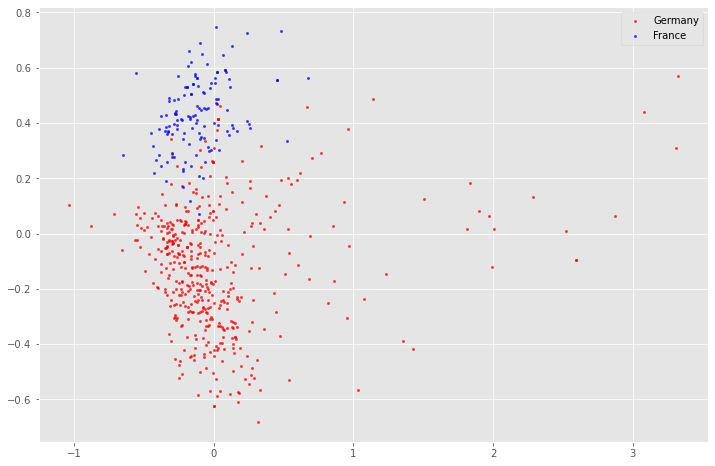

In [203]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(12, 8))
    plt.scatter(
        X_embedded[y == 0][:, 0], 
        X_embedded[y == 0][:, 1],
        alpha=0.8, s=5, c='r', 
        label='Germany')
    plt.scatter(
        X_embedded[y == 1][:, 0], 
        X_embedded[y == 1][:, 1],
        alpha=0.8, s=5, c='b',
        label='France')
    plt.legend();

# Embedding of Features (t-SNE)

In [142]:
from sklearn.manifold import TSNE

In [143]:
mask = (df.index.str.startswith('DE') | df.index.str.startswith('FR')) \
     & (~df.isna().all(axis=1))

df_subset = df[mask].copy()
df_subset = df_subset.applymap(lambda x: np.log10(x * 100_000) if x > 0 else -2)

In [196]:
X = df_subset.values
X = (X - X.min()) / (X.max() - X.min())
y = df_subset.index.str[:2].map({ 'DE': 0, 'FR': 1 })

tsne = TSNE(n_components=2, learning_rate=1000, perplexity=8)
X_embedded = tsne.fit_transform(X)

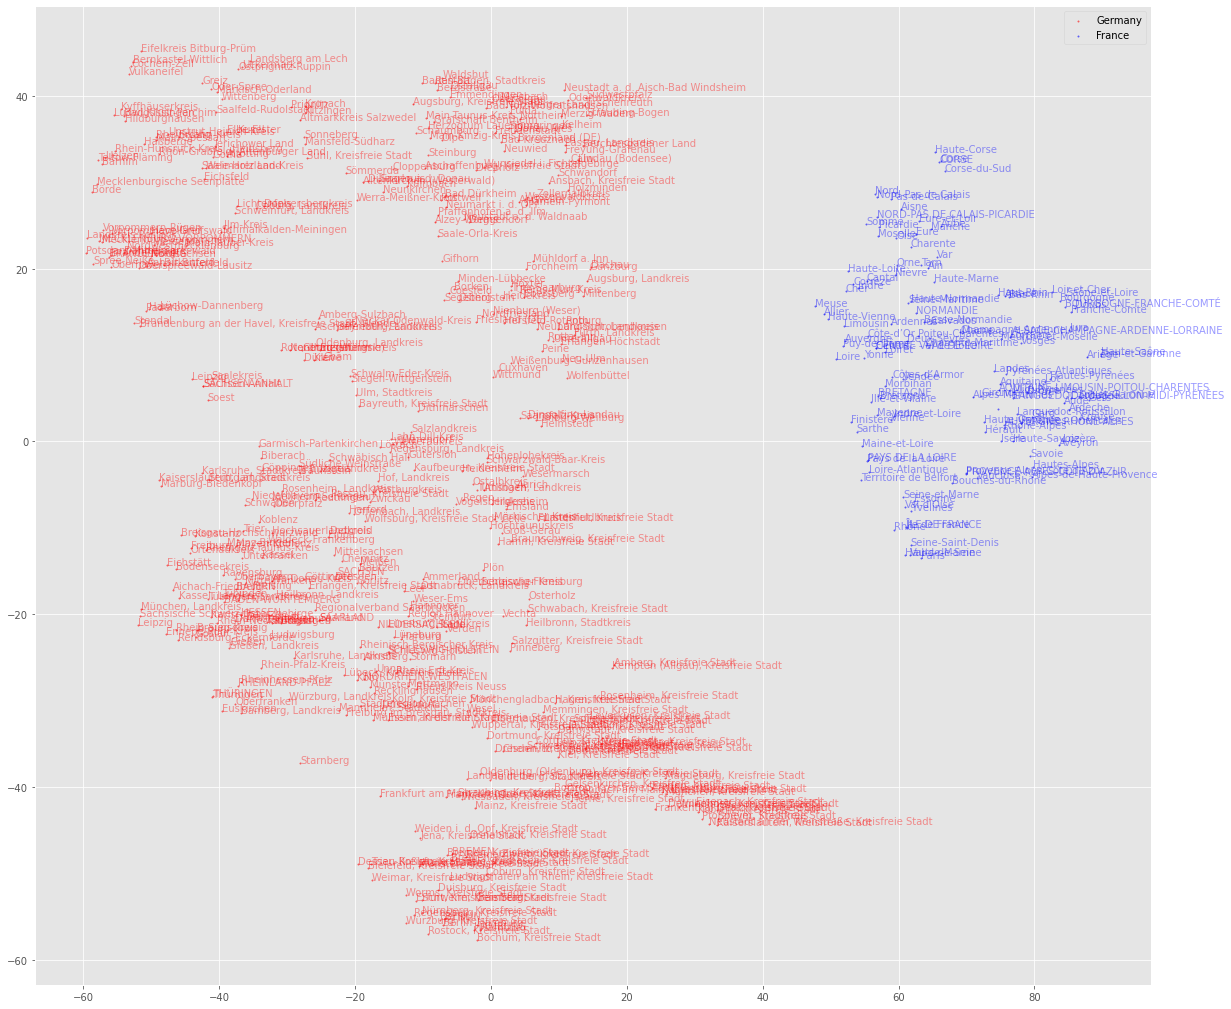

In [200]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(20, 18))
    plt.scatter(
        X_embedded[y == 0][:, 0], 
        X_embedded[y == 0][:, 1],
        alpha=0.5, s=2, c='r', 
        label='Germany')
    plt.scatter(
        X_embedded[y == 1][:, 0], 
        X_embedded[y == 1][:, 1],
        alpha=0.5, s=2, c='b',
        label='France')
    plt.legend();

    for i, row in gdf_nuts.loc[df_subset.index].reset_index().iterrows():
        if row['levl_code'] > 0:
            color = 'r' if row['nuts_id'].startswith('DE') else 'b'
            plt.annotate(
                row['nuts_name'], (
                    X_embedded[i, 0] + 0.00002, 
                    X_embedded[i, 1] + 0.00002
                ), 
                fontsize=10, 
                alpha=0.4, 
                color=color)